In [1]:
using SparseArrays
using BenchmarkTools
using Distributed
using Plots

## Comparing removing entries in sparse arrays

In [2]:
addprocs(4);
nprocs()
@everywhere begin 
    using BenchmarkTools
    using SparseArrays 
end

In [3]:
function sparse_remove_row_dist(;n=1000,m=1000,l=0.1,u=1.0,s=0.1)
    d = @distributed vcat for p = l:s:u
        t = @benchmark B = A[1:end .!= round($n/2),:] setup=(A=sprand($n,$m,$p))
        mean(t).time
    end
    return d
end

function sparse_remove_row(;n=1000,m=1000,l=0.1,u=1.0,s=0.1)
    d = []
    for p = l:s:u
        t = @benchmark B = A[1:end .!= round($n/2),:] setup=(A=sprand($n,$m,$p))
        push!(d, mean(t).time)
    end
    return d
end

sparse_remove_row (generic function with 1 method)

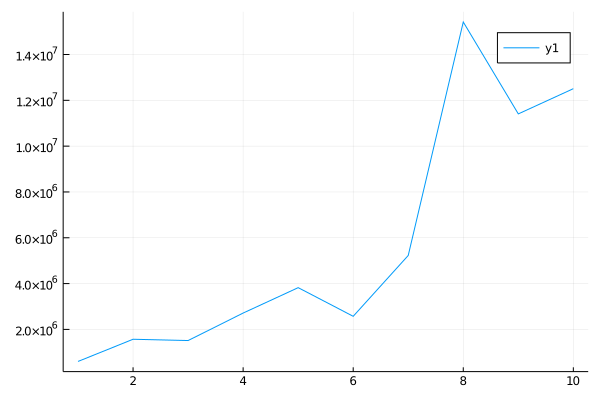

In [4]:
d = sparse_remove_row_dist()
plot(d)

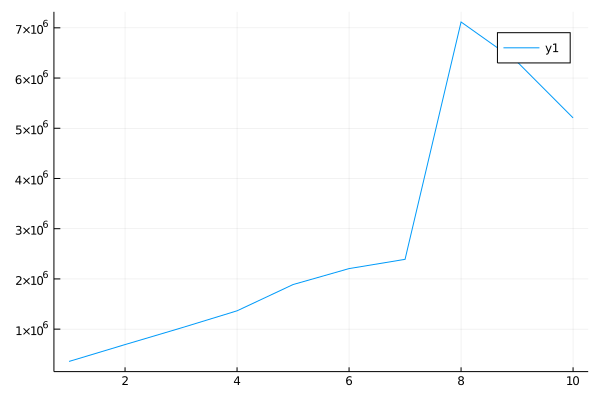

In [5]:
e = sparse_remove_row()
plot(e)

## dict-sparse storage

In [36]:
using DataStructures
mutable struct ConstraintEntry
    func::SparseVector{Float64}
    lim::Float64
end

In [46]:
function get_rand_constraint_set(;n=1000,m=1000,p=0.2)
    constraints = OrderedDict{Int, ConstraintEntry}()
    for i in 1:m
        constraints[i] = ConstraintEntry(sprand(n, p), rand(0:0.001:10))
    end
    return constraints
end

get_rand_constraint_set (generic function with 1 method)

In [41]:
get_rand_constraint_set()[3]

ConstraintEntry(  [2  ]  =  0.680604
  [5  ]  =  0.555345
  [9  ]  =  0.804533
  [11 ]  =  0.758258
  [13 ]  =  0.222011
  [19 ]  =  0.388371
  [37 ]  =  0.309591
  [38 ]  =  0.689896
  [46 ]  =  0.642225
  [49 ]  =  0.578966
         ⋮
  [64 ]  =  0.38883
  [72 ]  =  0.0115481
  [73 ]  =  0.163799
  [80 ]  =  0.76131
  [83 ]  =  0.153149
  [84 ]  =  0.598504
  [85 ]  =  0.956306
  [87 ]  =  0.952983
  [90 ]  =  0.0679748
  [91 ]  =  0.3584
  [98 ]  =  0.872586, 1.052)

In [48]:
GetConstraintMatrix(c::OrderedDict{Int, ConstraintEntry}) = reduce(hcat, [j.func for j in values(c)])'
GetConstraintVector(c::OrderedDict{Int, ConstraintEntry}) = reduce(hcat, [j.lim for j in values(c)])'

GetConstraintVector (generic function with 1 method)

In [49]:
@benchmark GetConstraintMatrix(c) setup=(c = get_rand_constraint_set())

BenchmarkTools.Trial: 
  memory estimate:  1.51 GiB
  allocs estimate:  27007
  --------------
  minimum time:     492.639 ms (8.72% GC)
  median time:      508.230 ms (11.12% GC)
  mean time:        539.520 ms (15.32% GC)
  maximum time:     801.459 ms (42.28% GC)
  --------------
  samples:          10
  evals/sample:     1